## **U-Net**
U-Net is an architecture for semantic segmentation. It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network.
It is built upon the fully convilutional network and modifed to yeild better segmentation in medical images.

The two main features of the U-Net architecture are:
* Encoder-Decoder structure
* Skip connection

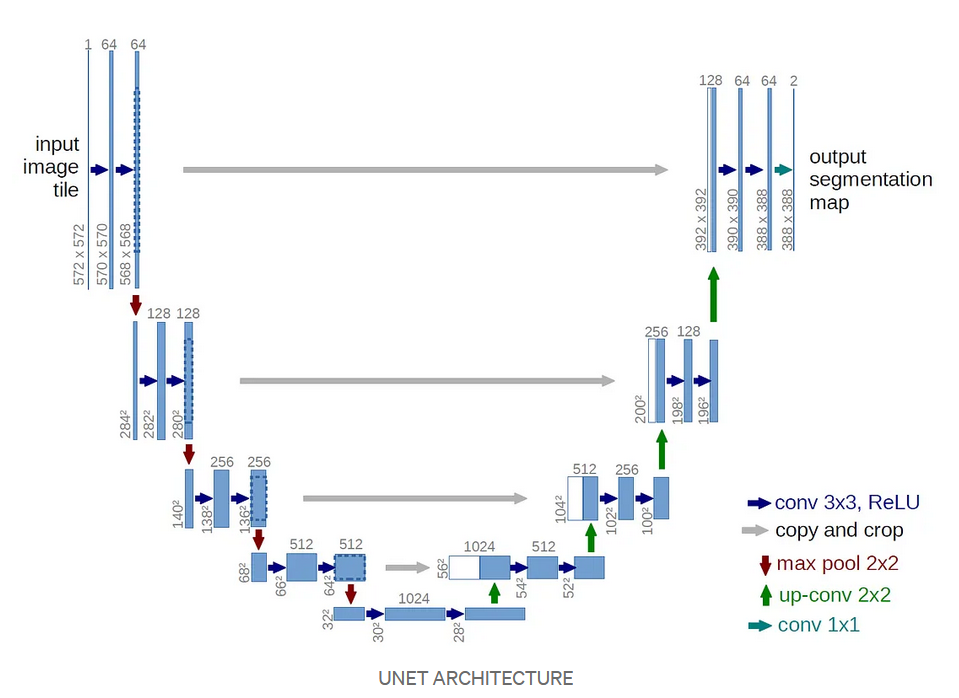

### Importing required libraries

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from keras.utils import plot_model

### Making the "Conv" Block

In [ ]:
def conv_block(inputs, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

In [ ]:
x = Input([256, 256, 3])
y = conv_block(x, 32)
print(y.shape)

(None, 256, 256, 32)


### Encoder Block

In [ ]:
def encoder_block(inputs, num_filters):
  x = conv_block(inputs, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

In [ ]:
x = Input([256, 256, 3])
s, p = encoder_block(x, 32)
print(s.shape, p.shape)

(None, 256, 256, 32) (None, 128, 128, 32)


Here we get output shape of skip connection - s and output of encoder block p

### Decoder Block

In [ ]:
def decoder_block(inputs, skip, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
  x = Concatenate()([x, skip])
  x = conv_block(x, num_filters)
  return x

In [ ]:
x = Input([256, 256, 3])
s = Input([512, 512, 3])
y = decoder_block(x, s, 32)
print(y.shape)

(None, 512, 512, 32)


>**Note**: Both Image and Mask will have the same size

### Simple U-Net implementation

In [ ]:
def build_unet(input_shape):
  inputs = Input(input_shape)

  """ Encoder Block """
  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  print(s1.shape, s2.shape, s3.shape, s4.shape)

  """ Bridge Connection Encoder---Decoder """
  b1 = conv_block(p4, 1024)

  """ Decoder Block """
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4) # returns binary segmentation mask

  model = Model(inputs, outputs, name="Unet")
  return model

### Visualization of the Unet model

In [ ]:
input_shape = (256, 256, 3)
model = build_unet(input_shape)

(None, 256, 256, 64) (None, 128, 128, 128) (None, 64, 64, 256) (None, 32, 32, 512)


In [ ]:
# model summary
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_86 (Conv2D)          (None, 256, 256, 64)         1792      ['input_15[0][0]']            
                                                                                                  
 batch_normalization_84 (Ba  (None, 256, 256, 64)         256       ['conv2d_86[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_84 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_84[0]

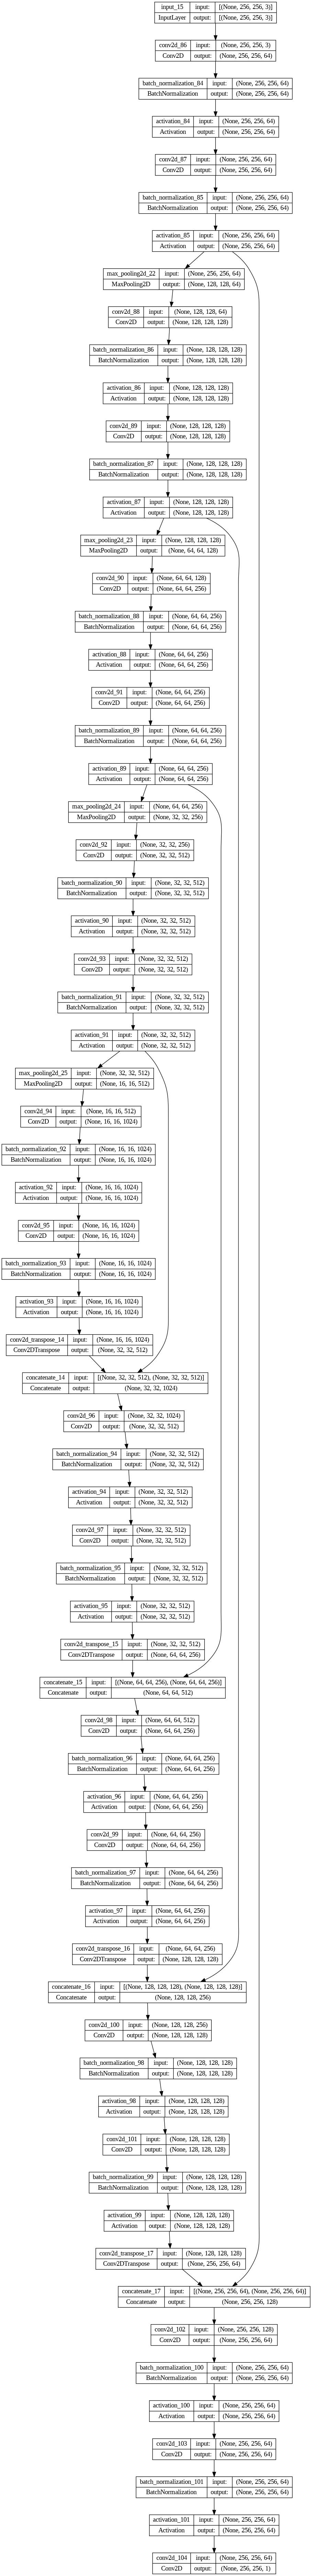

In [ ]:
# model architecture
plot_model(model, show_shapes=True)